# Approach 2

Getting back into it after some time with a new approach for finding patterns. Initial exploration and analysis.

### Init

In [1]:
import polars as pl
from polars import selectors as cs
from matplotlib import pyplot as plt
import os
import statsmodels.api as sm

### Load and unpivot

In [2]:
path = os.path.join('data', 'silver', 'prices_with_nrdy')

df = pl.read_parquet(path)


In [3]:
display(df)

date,ticker,price
date,str,f64
1994-03-18,"""SCSC""",1.71875
1994-03-21,"""SCSC""",1.90625
1994-03-22,"""SCSC""",1.9375
1994-03-23,"""SCSC""",2.09375
1994-03-24,"""SCSC""",2.09375
…,…,…
2024-04-26,"""NRDY""",2.76
2024-04-29,"""NRDY""",2.71
2024-04-30,"""NRDY""",2.59


### Plot price over time

In [6]:
def plot_price(df, ticker=None, x='date', y='price'):
    if not ticker:
        ticker = ''

    dates = df[x]
    prices = df[y]

    fig, ax = plt.subplots()
    ax.plot(dates, prices)
    # ax.scatter(dates, prices, s=5)
    plt.title(ticker)
    plt.show()
    

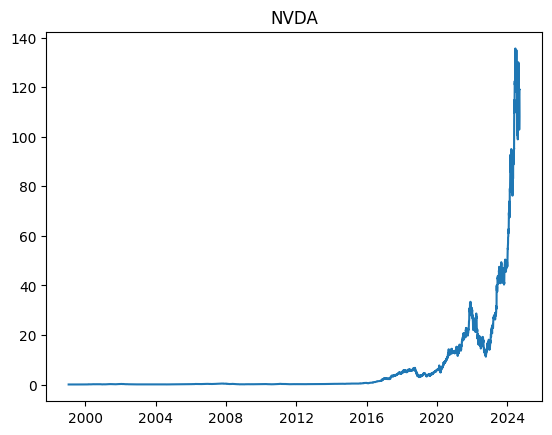

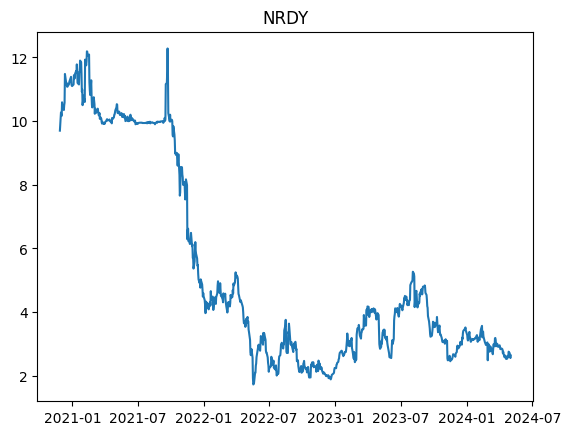

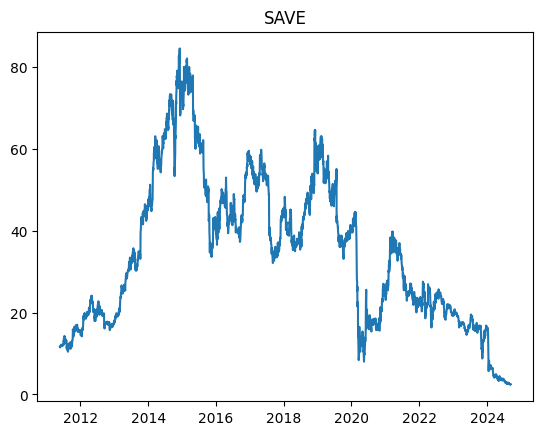

In [7]:
test_tickers = ['NRDY', 'NVDA', 'SAVE']

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))

for ticker, group_df in filtered_df.group_by('ticker'):
    plot_price(group_df, ticker[0])



### Detrending

In [158]:
def detrend_lin_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns
    assert 'ticker' in df.columns
    assert df['ticker'].unique().count() == 1

    ticker = df['ticker'][0]

    df = df.sort(pl.col('date'))

    rows, cols = df.shape

    # create X and y
    X = list(range(0, rows))
    X = sm.add_constant(X)
    y = df['price'].to_numpy()

    # fit model
    model = sm.OLS(y, X)
    results = model.fit()

    # make predictions
    predictions = results.predict()

    # detrend using model predictions
    df = df.with_columns(pl.col('price') - predictions)

    if DEBUG:
        print(results.summary())

        fig, ax = plt.subplots()
        ax.scatter(X[:,1], y, s=5)
        ax.plot(X[:,1], predictions)
        ax.plot(X[:,1], df['price'])
        ax.set_title(ticker)
        plt.show()

    
    return df



In [159]:
def detrend_exp_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns

    df = df.with_columns(pl.col('price').log1p())

    df = detrend_lin_reg(df)

    return df



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     4265.
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:46:49   Log-Likelihood:                -17694.
No. Observations:                6422   AIC:                         3.539e+04
Df Residuals:                    6420   BIC:                         3.541e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9422      0.095     62.577      0.0

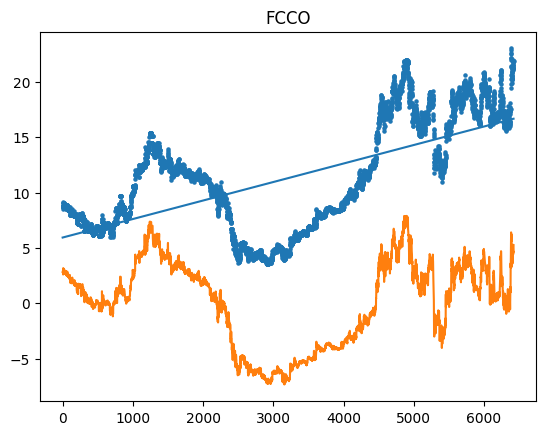

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     2647.
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:46:49   Log-Likelihood:                -26651.
No. Observations:                6453   AIC:                         5.331e+04
Df Residuals:                    6451   BIC:                         5.332e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.1105      0.375    -26.990      0.0

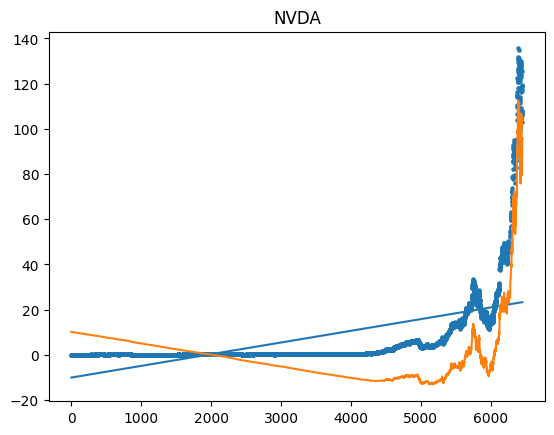

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                 1.966e+04
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:46:49   Log-Likelihood:                -28697.
No. Observations:                6250   AIC:                         5.740e+04
Df Residuals:                    6248   BIC:                         5.741e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6049      0.604      9.281      0.0

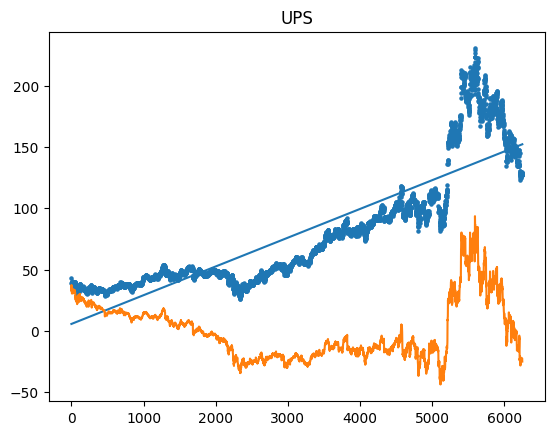

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                 4.522e+04
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:46:49   Log-Likelihood:                -42437.
No. Observations:               13184   AIC:                         8.488e+04
Df Residuals:                   13182   BIC:                         8.489e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.7346      0.105    -73.407      0.0

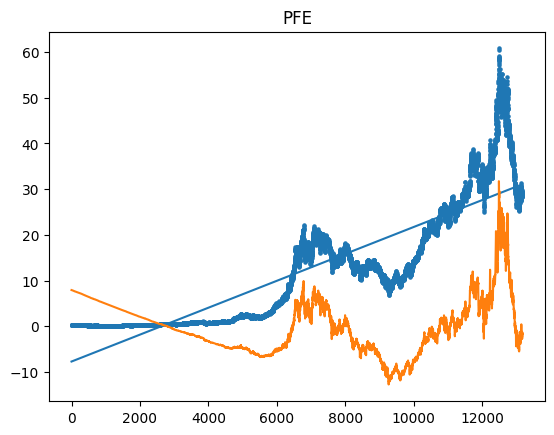

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     1690.
Date:                Sat, 21 Jun 2025   Prob (F-statistic):          1.06e-200
Time:                        01:46:49   Log-Likelihood:                -4286.1
No. Observations:                 815   AIC:                             8576.
Df Residuals:                     813   BIC:                             8586.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        183.4309      3.261     56.254      0.0

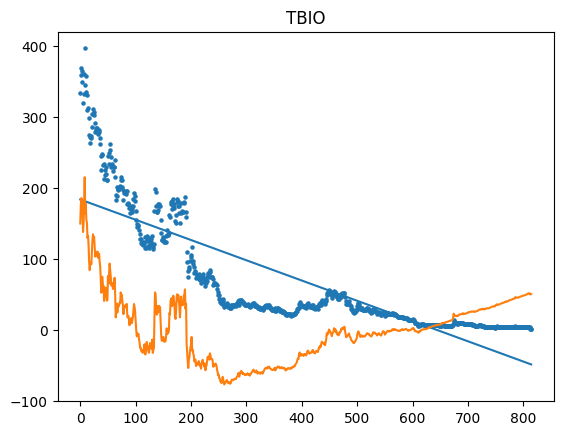

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     833.0
Date:                Sat, 21 Jun 2025   Prob (F-statistic):          6.92e-171
Time:                        01:46:50   Log-Likelihood:                -21451.
No. Observations:                5602   AIC:                         4.291e+04
Df Residuals:                    5600   BIC:                         4.292e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8761      0.298     46.628      0.0

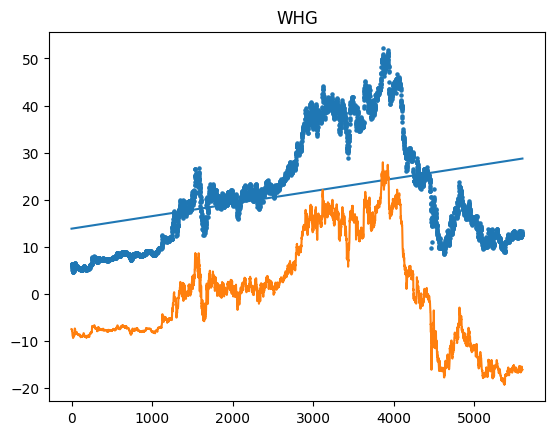

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     1614.
Date:                Sat, 21 Jun 2025   Prob (F-statistic):          1.61e-199
Time:                        01:46:50   Log-Likelihood:                -1770.9
No. Observations:                 862   AIC:                             3546.
Df Residuals:                     860   BIC:                             3555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7880      0.129     76.084      0.0

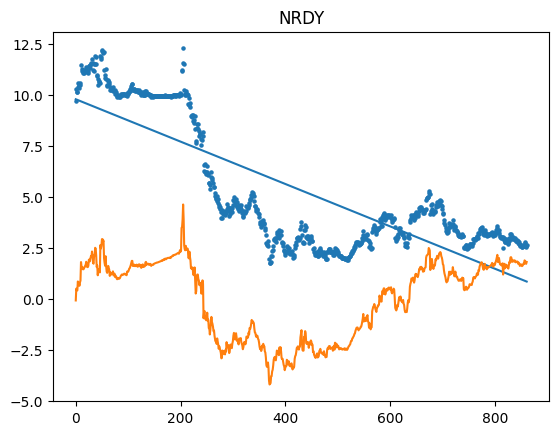

In [160]:
# DEBUG = True
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_lin_reg)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     573.9
Date:                Sat, 21 Jun 2025   Prob (F-statistic):          3.42e-117
Time:                        01:47:23   Log-Likelihood:                -2994.9
No. Observations:                3347   AIC:                             5994.
Df Residuals:                    3345   BIC:                             6006.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8215      0.020    186.693      0.0

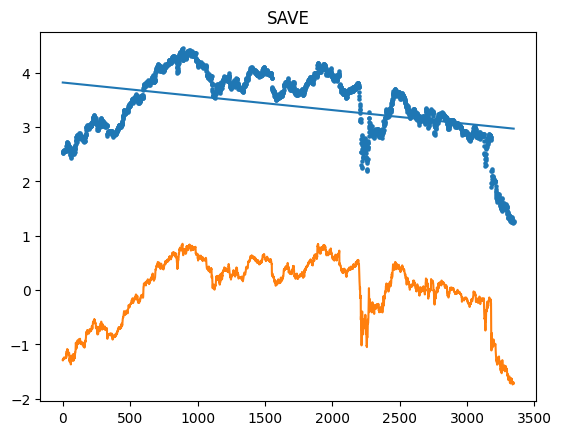

In [161]:
DEBUG = True
detrended_df = df.filter(pl.col('ticker') == 'SAVE')

detrended_df = detrend_exp_reg(detrended_df)




                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     1369.
Date:                Sat, 21 Jun 2025   Prob (F-statistic):          4.57e-180
Time:                        01:39:20   Log-Likelihood:                -159.36
No. Observations:                 862   AIC:                             322.7
Df Residuals:                     860   BIC:                             332.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3621      0.020    119.080      0.0

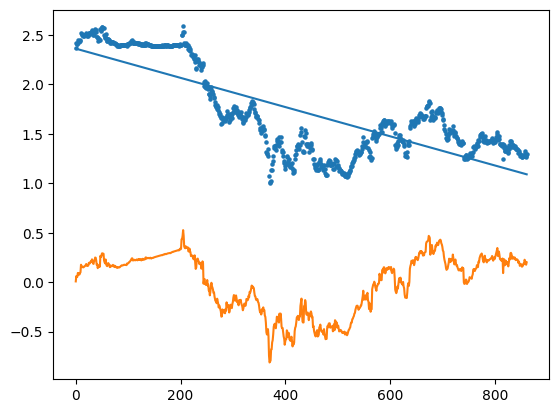

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                 1.324e+04
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:39:20   Log-Likelihood:                -6917.3
No. Observations:                6453   AIC:                         1.384e+04
Df Residuals:                    6451   BIC:                         1.385e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8503      0.018    -48.315      0.0

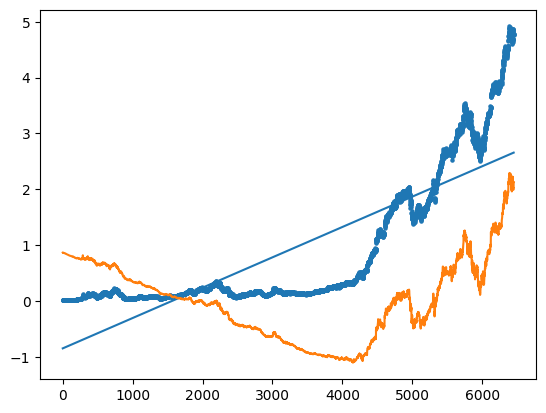

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     573.9
Date:                Sat, 21 Jun 2025   Prob (F-statistic):          3.42e-117
Time:                        01:39:20   Log-Likelihood:                -2994.9
No. Observations:                3347   AIC:                             5994.
Df Residuals:                    3345   BIC:                             6006.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8215      0.020    186.693      0.0

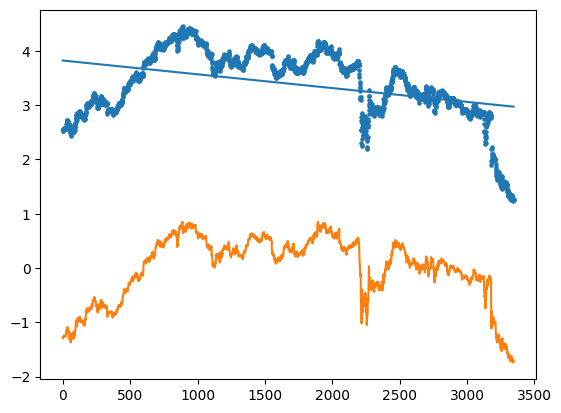

In [134]:
detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

# plot_price(detrend_lin_reg(detrended_df))
detrended_df = detrended_df.group_by('ticker').map_groups(detrend_exp_reg)

Regression detrending isn't working well on tickers that have two distinct trends. 